In [1]:
# Import necessary libraries
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image, ImageDraw
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def drawing_to_image(drawing, image_size=256, line_width=2):
    # Convert a drawing (list of strokes) to a grayscale image.
    # Each stroke is a list: [list_of_x, list_of_y].
    
    # Create a white image
    img = Image.new("L", (image_size, image_size), color=255)
    draw = ImageDraw.Draw(img)
    
    # Draw each stroke as a line. We iterate over strokes.
    for stroke in drawing:
        x_points, y_points = stroke
        if len(x_points) > 1:
            # Create a list of (x, y) tuples
            points = list(zip(x_points, y_points))
            draw.line(points, fill=0, width=line_width)
    return np.array(img)

In [5]:
def load_ndjson_file(file_path, label, max_samples=500):  
    # Read an NDJSON file and convert each drawing into an image.
    # Limits the number of samples to avoid memory issues.
    
    images = []
    labels = []
    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i >= max_samples:  # Stop if we reach the limit
                break
            data = json.loads(line)
            drawing = data["drawing"]
            img_array = drawing_to_image(drawing)
            images.append(img_array)
            labels.append(label)
    return images, labels


In [4]:
# Define categories
animals = ['dog', 'ant', 'bear', 'bee', 'bird', 'butterfly',
           'camel', 'cat', 'cow', 'crab', 'crocodile', 'dolphin', 'dragon']

data_dir = "C:/Users/Andrea Nelson/Downloads/QuickDrawDatasetSimplified"
all_images = []
all_labels = []
max_samples_per_class = 1000  # number of images to use for each category

# Load data with a sample limit
for animal in animals:
    file_name = f"full_simplified_{animal}.ndjson"
    file_path = os.path.join(data_dir, file_name)
    
    if os.path.exists(file_path):
        imgs, labs = load_ndjson_file(file_path, animal, max_samples=max_samples_per_class)
        all_images.extend(imgs)
        all_labels.extend(labs)
        print(f"Loaded {len(imgs)} images for {animal}")
    else:
        print(f"File {file_path} not found. Skipping {animal}.")

print("Total images loaded:", len(all_images))


Loaded 1000 images for dog
Loaded 1000 images for ant
Loaded 1000 images for bear
Loaded 1000 images for bee
Loaded 1000 images for bird
Loaded 1000 images for butterfly
Loaded 1000 images for camel
Loaded 1000 images for cat
Loaded 1000 images for cow
Loaded 1000 images for crab
Loaded 1000 images for crocodile
Loaded 1000 images for dolphin
Loaded 1000 images for dragon
Total images loaded: 13000


In [5]:
# Convert list of images to numpy array and normalize
X = np.array(all_images)
X = np.expand_dims(X, -1).astype("float32") / 255.0  

# Encode labels
le = LabelEncoder()
y = le.fit_transform(all_labels)
num_classes = len(le.classes_)

print("X shape:", X.shape)
print("Unique labels:", np.unique(y))


X shape: (13000, 256, 256, 1)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 10400
Validation samples: 2600


### Data Clustering

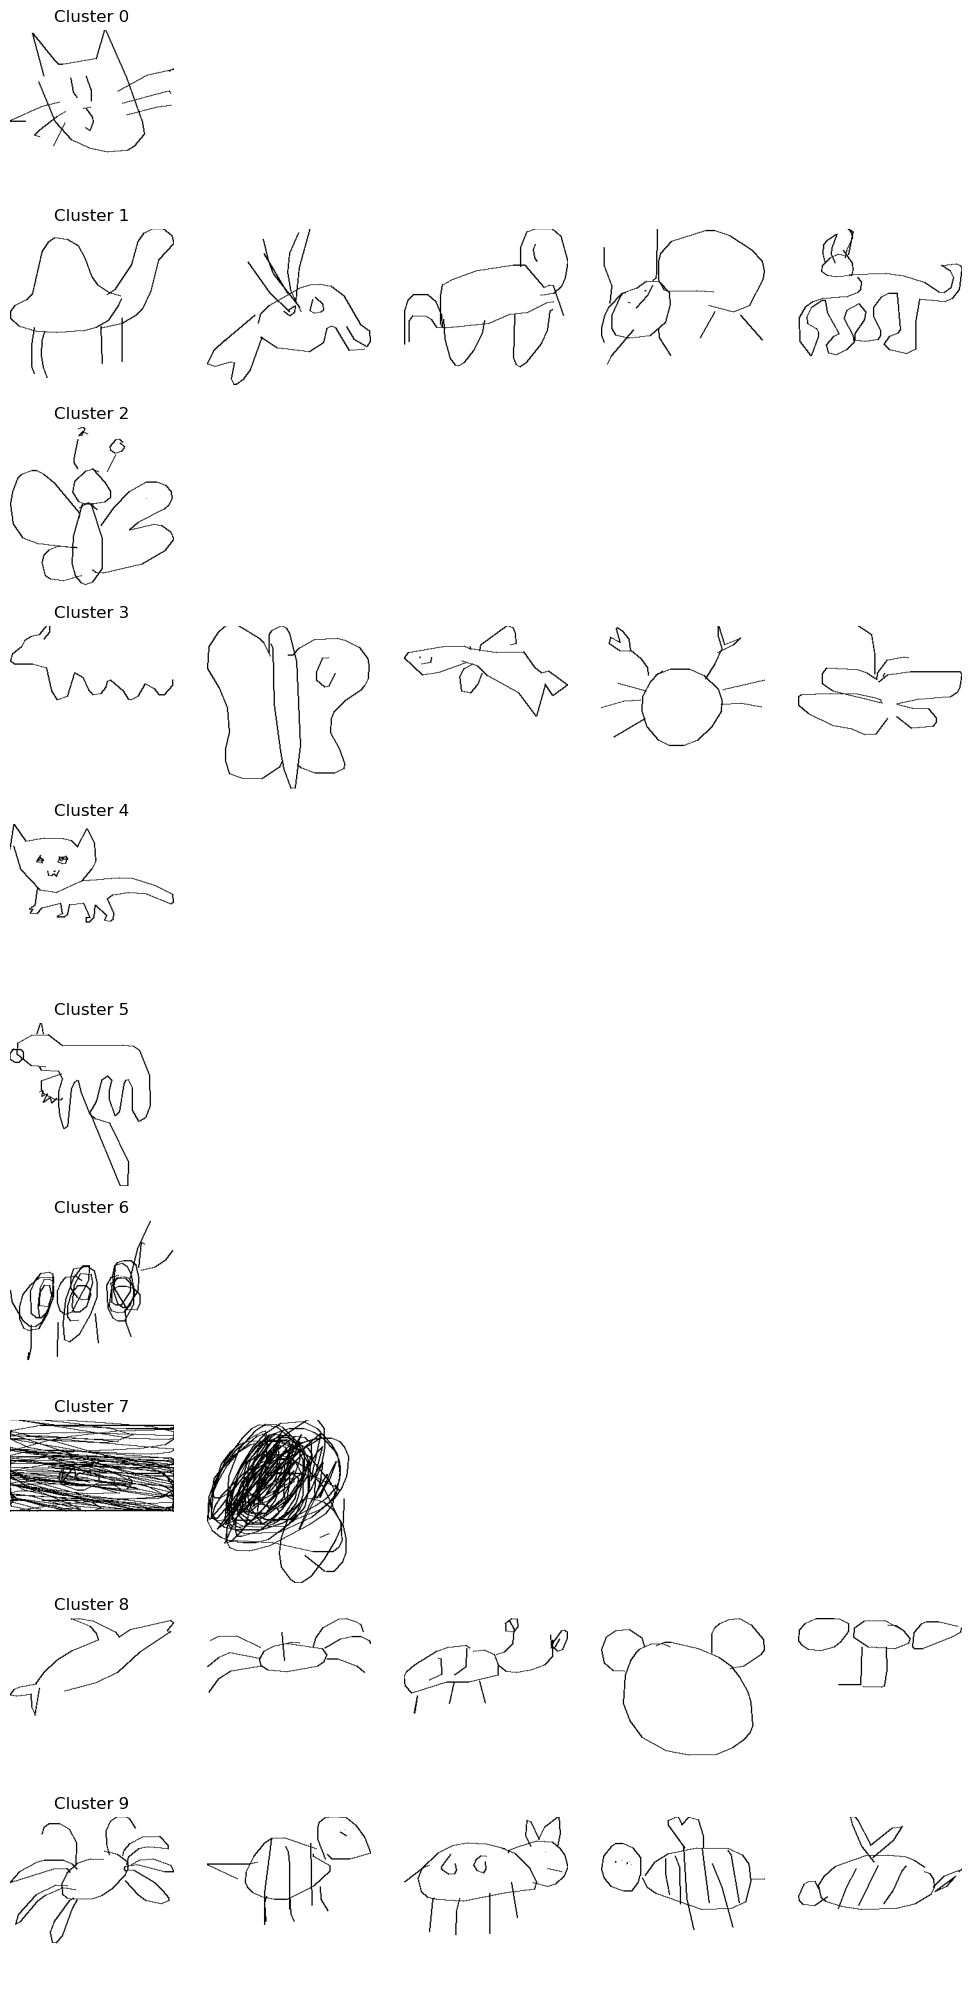

In [99]:
# Flatten images for clustering
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (num_samples, height*width*channels)

# Perform K-Means clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_flat)  # Shape: (num_samples,)

# Function to plot sample images from each cluster
def plot_clustered_images(X_train, cluster_labels, num_clusters, max_samples=5):
    fig, axes = plt.subplots(num_clusters, max_samples, figsize=(max_samples * 2, num_clusters * 2))

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Find images in this cluster
        num_images = min(len(cluster_indices), max_samples)  # Only take as many as exist

        # Ensure axes is always iterable (for cases where num_images < max_samples)
        for i, ax in enumerate(axes[cluster] if num_clusters > 1 else [axes]):
            if i < num_images:
                idx = cluster_indices[i]
                ax.imshow(X_train[idx].squeeze(), cmap="gray")  # Assuming grayscale images
            ax.axis("off")

        # Set title for the first image in the row
        axes[cluster, 0].set_title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()

# Call function to display images
plot_clustered_images(X_train, cluster_labels, num_clusters, max_samples=5)



## Creating functions to be used for evaluation

In [9]:

# Function to compute F1 Score
def f1_score(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int32)  # Ensure output type is int32
    y_true = tf.cast(y_true, tf.int32)  # Ensure true labels are int32

    tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, y_pred_classes), tf.equal(y_true, 1)), tf.float32))
    fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, y_pred_classes), tf.equal(y_pred_classes, 1)), tf.float32))
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, y_pred_classes), tf.equal(y_true, 1)), tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

In [18]:
def plot_f1_scores(history):
    """
    Function to plot the F1 scores during training and validation over epochs.

    Parameters:
    history: The history object returned by model.fit()
    """
    plt.figure(figsize=(10, 6))

    # Plot F1 Score
    plt.plot(history.history["f1_score"], label="train_f1_score", color="blue")
    plt.plot(history.history["val_f1_score"], label="val_f1_score", color="orange")

    # Titles and labels
    plt.title("F1 Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.show()


In [8]:
def plot_training_history(history):
    """
    Function to plot the training and validation loss & accuracy.
    
    Parameters:
    history: The history object returned by model.fit()
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


In [127]:
def plot_comparison(histories, labels):
    """
    Plots the training & validation accuracy/loss for multiple models.
    
    Parameters:
    histories: List of history objects from model.fit()
    labels: List of model names corresponding to the histories
    """
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history["loss"], label=f"{label} - Train Loss")
        plt.plot(history.history["val_loss"], linestyle="dashed", label=f"{label} - Val Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history["accuracy"], label=f"{label} - Train Acc")
        plt.plot(history.history["val_accuracy"], linestyle="dashed", label=f"{label} - Val Acc")
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


In [147]:
def plot_f1_score_comparison(histories, model_names):
    """
    Function to plot a bar graph comparing F1 scores of different models.

    Parameters:
    histories: List of history objects returned by model.fit()
    model_names: List of names corresponding to each model
    """
    num_models = len(histories)
    final_f1_scores = [history.history["val_f1_score"][-1] for history in histories]  # Get last epoch val F1 scores

    # Set bar positions
    x = np.arange(num_models)
    
    # Create the bar plot
    plt.figure(figsize=(8, 5))
    plt.bar(x, final_f1_scores, color=['blue', 'orange', 'green'], alpha=0.7)

    # Adjust y-axis limit to add space above bars
    plt.ylim(0, max(final_f1_scores) + 0.05)  # Increase max limit slightly

    # Add labels
    plt.xticks(x, model_names)
    plt.ylabel("Final Validation F1 Score")
    plt.title("Comparison of F1 Scores Across Models")

    # Display values on bars
    for i, v in enumerate(final_f1_scores):
        plt.text(i, v + 0.01, f"{v:.4f}", ha="center", fontsize=12)

    plt.show()

# Example usage
# plot_f1_score_comparison([history1, history2, history3], ["Model A", "Model B", "Model C"])


In [173]:
def display_results_table(histories, model_names):
    results = []

    for name, history in zip(model_names, histories):
        final_train_acc = round(history.history["accuracy"][-1], 3)
        final_val_acc = round(history.history["val_accuracy"][-1], 3)
        final_train_loss = round(history.history["loss"][-1], 3)
        final_val_loss = round(history.history["val_loss"][-1], 3)
        final_train_f1 = round(history.history["f1_score"][-1], 3)
        final_val_f1 = round(history.history["val_f1_score"][-1], 3)

        results.append([name, final_train_acc, final_val_acc, final_train_loss, final_val_loss, final_train_f1, final_val_f1])

    # Create a Pandas DataFrame
    df = pd.DataFrame(results, columns=["Model", "Train Accuracy", "Val Accuracy", "Train Loss", "Val Loss", "Train F1", "Val F1"])

    # Apply styling for better presentation
    styled_df = df.style.set_caption("Model Performance Comparison") \
        .format(precision=3) \
        .set_table_styles([
            {"selector": "caption", "props": "font-size:16px; font-weight:bold; color:#333; text-align: center;"},
            {"selector": "thead th", "props": "background-color: #4CAF50; color: white; font-weight: bold;"},
            {"selector": "tbody td", "props": "text-align: center; font-size: 12px;"},
            {"selector": "tbody tr:nth-child(even)", "props": "background-color: #f2f2f2;"},
            {"selector": "tbody tr:hover", "props": "background-color: #ddd;"}
        ])

    # Display the styled table
    display(styled_df)


### Adjusting the Number of Filters in CNN Layers
Experimenting with different numbers of filters in the convolutional layers to improve feature extraction. More filters might allow the model to capture more complex patterns.  
- Test 1: 16 filters in first layer, 32 in second, 64 in third
- Test 2: 32 filters in first layer, 64 in second, 128 in third
- Test 3: 64 filters in first layer, 128 in second, 256 in third

In [20]:
def build_cnn_lstm_model_filter1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # CNN: extract spatial features
    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # x has shape (batch, H, W, channels). Reshape it to (batch, time_steps, features)
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x)  # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)
    
    # RNN: model sequential dependencies using LSTM
    x = layers.LSTM(128, return_sequences=False)(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_filter1(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",f1_score])
model.summary()

# Train the model
history1 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,147,021 (4.38 MB)

 Trainable params: 1,147,021 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.1568 - f1_score: 0.1235 - loss: 2.4251 - val_accuracy: 0.3473 - val_f1_score: 0.3080 - val_loss: 1.9746
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 76s 233ms/step - accuracy: 0.3931 - f1_score: 0.3249 - loss: 1.8496 - val_accuracy: 0.4769 - val_f1_score: 0.4604 - val_loss: 1.5973
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 77s 236ms/step - accuracy: 0.5325 - f1_score: 0.4313 - loss: 1.4288 - val_accuracy: 0.5615 - val_f1_score: 0.4796 - val_loss: 1.3595
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 75s 231ms/step - accuracy: 0.6544 - f1_score: 0.5370 - loss: 1.0904 - val_accuracy: 0.6046 - val_f1_score: 0.5080 - val_loss: 1.2700
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 76s 233ms/step - accuracy: 0.7288 - f1_score: 0.6080 - loss: 0.8362 - val_accuracy: 0.6138 - val_f1_score: 0.4874 - val_loss: 1.2822
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 74s 229ms/step - accuracy: 0.8082 - f1_score: 0.6915 - loss: 0.6020 - val_accuracy: 0.6088 - va

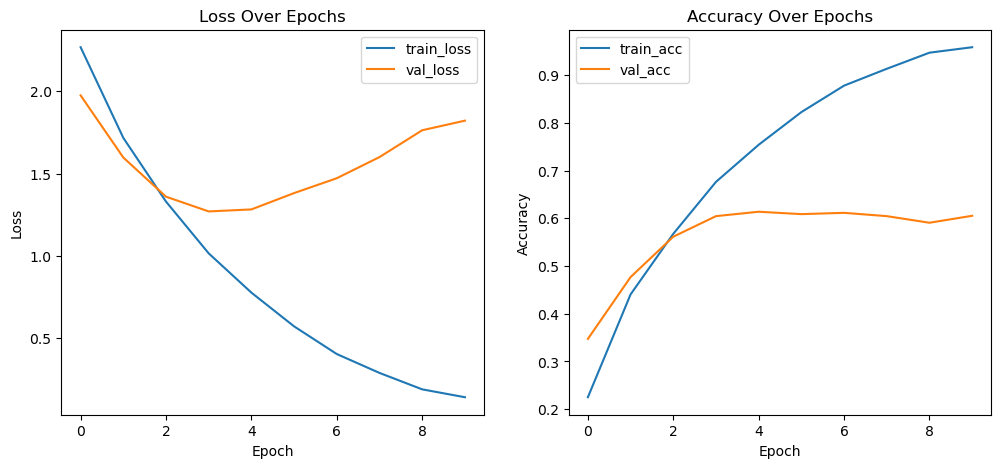

In [22]:
plot_training_history(history1)

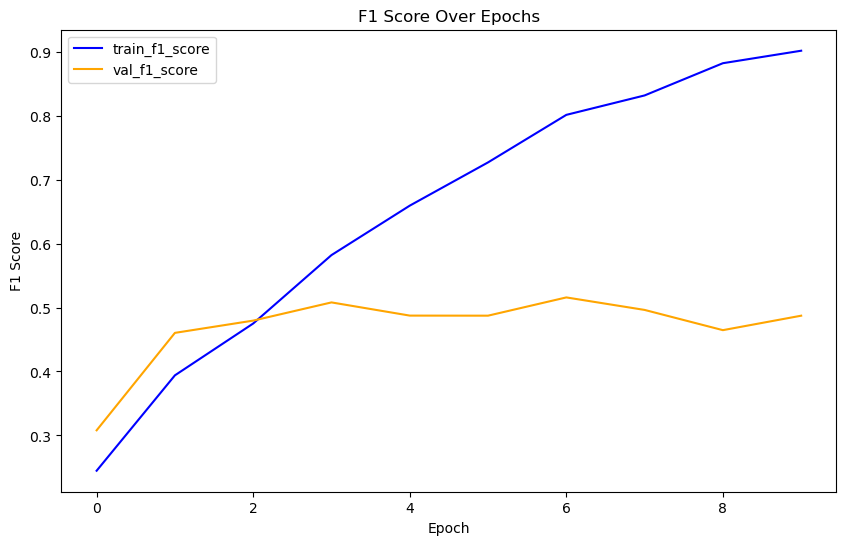

In [24]:
plot_f1_scores(history1)

#### Test 2: 32 filters in first layer, 64 in second, 128 in third

In [27]:
def build_cnn_lstm_model_filter2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # CNN: extract spatial features
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # x has shape (batch, H, W, channels). Reshape it to (batch, time_steps, features)
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x)  # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)
    
    # RNN: model sequential dependencies using LSTM
    x = layers.LSTM(128, return_sequences=False)(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_filter2(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",f1_score])
model.summary()

# Train the model
history2 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │     2,163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,973 (8.64 MB)

 Trainable params: 2,264,973 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 217s 658ms/step - accuracy: 0.1546 - f1_score: 0.1126 - loss: 2.4427 - val_accuracy: 0.3427 - val_f1_score: 0.3576 - val_loss: 1.9775
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 213s 655ms/step - accuracy: 0.3916 - f1_score: 0.3149 - loss: 1.8498 - val_accuracy: 0.4754 - val_f1_score: 0.4465 - val_loss: 1.6230
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 220s 676ms/step - accuracy: 0.5334 - f1_score: 0.4507 - loss: 1.4436 - val_accuracy: 0.5369 - val_f1_score: 0.4823 - val_loss: 1.4582
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 210s 645ms/step - accuracy: 0.6386 - f1_score: 0.5532 - loss: 1.1341 - val_accuracy: 0.5677 - val_f1_score: 0.4779 - val_loss: 1.3839
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 208s 639ms/step - accuracy: 0.7287 - f1_score: 0.6486 - loss: 0.8671 - val_accuracy: 0.5823 - val_f1_score: 0.5091 - val_loss: 1.4043
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 209s 642ms/step - accuracy: 0.7996 - f1_score: 0.7248 - loss: 0.6358 - val_accuracy: 0.570

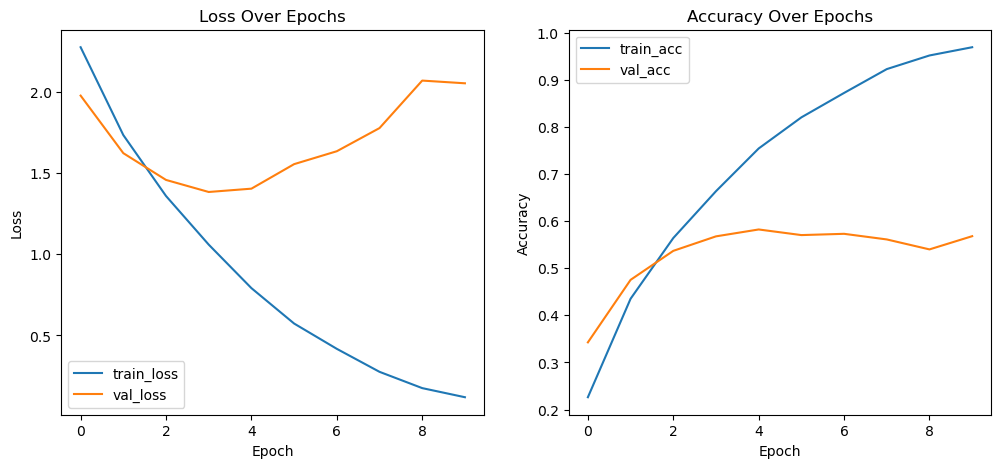

In [28]:
plot_training_history(history2)

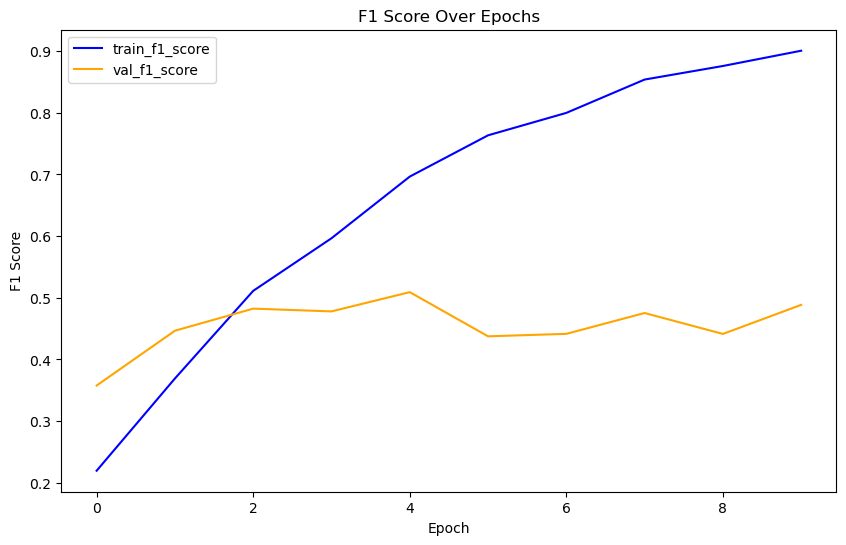

In [29]:
plot_f1_scores(history2)

#### Test 3: 64 filters in first layer, 128 in second, 256 in third

In [31]:
def build_cnn_lstm_model_filter3(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # CNN: extract spatial features
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # x has shape (batch, H, W, channels). Reshape it to (batch, time_steps, features)
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x)  # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)
    
    # RNN: model sequential dependencies using LSTM
    x = layers.LSTM(128, return_sequences=False)(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_filter3(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",f1_score])
model.summary()

# Train the model
history3 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_2 (Permute)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 8192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │     4,260,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,639,117 (17.70 MB)

 Trainable params: 4,639,117 (17.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.1640 - f1_score: 0.1314 - loss: 2.4188 - val_accuracy: 0.3858 - val_f1_score: 0.2925 - val_loss: 1.8650
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.4165 - f1_score: 0.3131 - loss: 1.7567 - val_accuracy: 0.5062 - val_f1_score: 0.4169 - val_loss: 1.5163
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.5486 - f1_score: 0.4386 - loss: 1.3954 - val_accuracy: 0.5531 - val_f1_score: 0.4132 - val_loss: 1.3883
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.6536 - f1_score: 0.5411 - loss: 1.0812 - val_accuracy: 0.5738 - val_f1_score: 0.4873 - val_loss: 1.3511
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.7447 - f1_score: 0.6286 - loss: 0.7955 - val_accuracy: 0.5958 - val_f1_score: 0.4923 - val_loss: 1.3610
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.8240 - f1_score: 0.7389 - loss: 0.5565 - val_accuracy: 0.5850 - val_f1_score: 

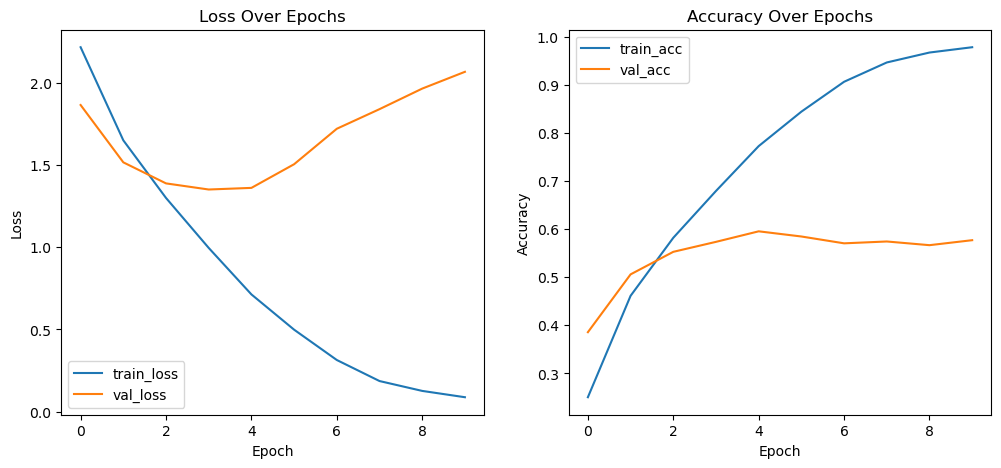

In [32]:
plot_training_history(history3)

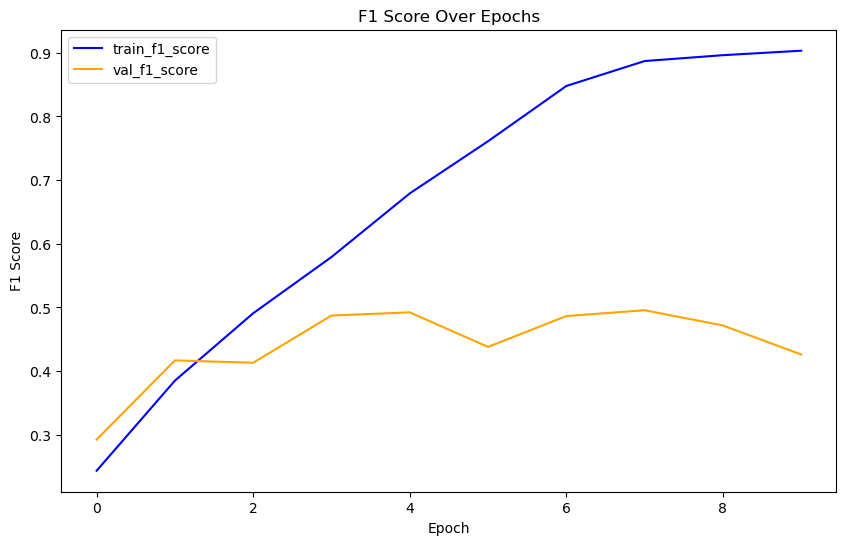

In [33]:
plot_f1_scores(history3)

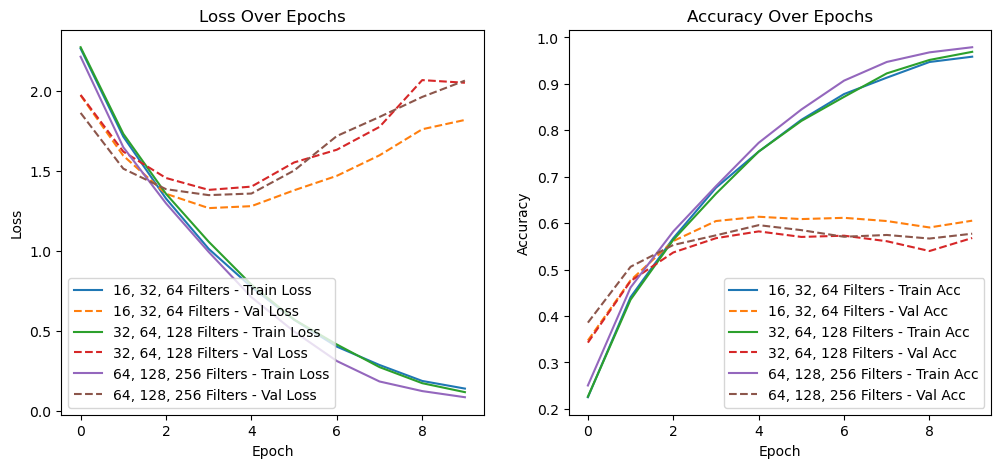

In [131]:
plot_comparison([history1, history2, history3], ["16, 32, 64 Filters", "32, 64, 128 Filters", "64, 128, 256 Filters"])

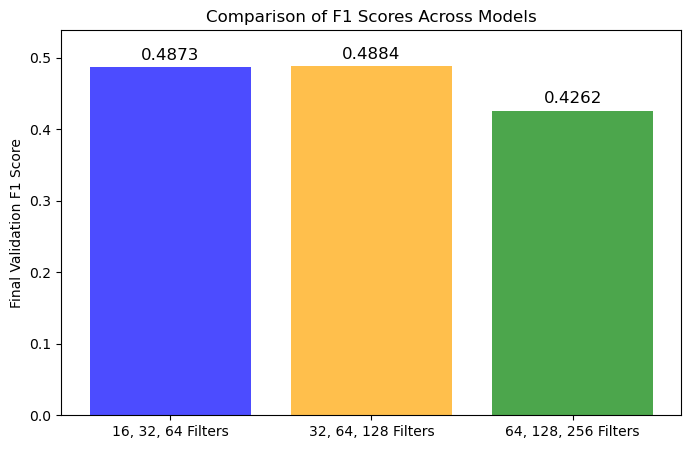

In [149]:
plot_f1_score_comparison([history1, history2, history3], ["16, 32, 64 Filters", "32, 64, 128 Filters", "64, 128, 256 Filters"])

In [175]:
display_results_table([history1, history2, history3], ["16, 32, 64 Filters", "32, 64, 128 Filters", "64, 128, 256 Filters"])

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Train F1,Val F1
0,"16, 32, 64 Filters",0.959,0.605,0.142,1.821,0.902,0.487
1,"32, 64, 128 Filters",0.969,0.568,0.120,2.053,0.901,0.488
2,"64, 128, 256 Filters",0.979,0.577,0.088,2.067,0.903,0.426


### Adding dropout layers

In [35]:
def build_cnn_lstm_model_dropout(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part: extract spatial features
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)  # Stronger dropout for deeper layers

    
    # x has shape (batch, H, W, channels). Reshape it to (batch, time_steps, features)
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x)  # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)
    
    # RNN: model sequential dependencies using LSTM
    x = layers.LSTM(128, return_sequences=False)(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_dropout(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_score])
model.summary()
    
# Train the model
history4 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_3 (Permute)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │     2,163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,973 (8.64 MB)

 Trainable params: 2,264,973 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 245s 738ms/step - accuracy: 0.0950 - f1_score: 0.0224 - loss: 2.5550 - val_accuracy: 0.2819 - val_f1_score: 0.2801 - val_loss: 2.1410
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 242s 745ms/step - accuracy: 0.3363 - f1_score: 0.2772 - loss: 1.9968 - val_accuracy: 0.4550 - val_f1_score: 0.3994 - val_loss: 1.6994
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 230s 709ms/step - accuracy: 0.4982 - f1_score: 0.4152 - loss: 1.5349 - val_accuracy: 0.5196 - val_f1_score: 0.4080 - val_loss: 1.5068
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 232s 715ms/step - accuracy: 0.5817 - f1_score: 0.4987 - loss: 1.2899 - val_accuracy: 0.5512 - val_f1_score: 0.4618 - val_loss: 1.4014
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 236s 727ms/step - accuracy: 0.6534 - f1_score: 0.5250 - loss: 1.0832 - val_accuracy: 0.5731 - val_f1_score: 0.4622 - val_loss: 1.3089
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 236s 725ms/step - accuracy: 0.7001 - f1_score: 0.5956 - loss: 0.9205 - val_accuracy: 0.599

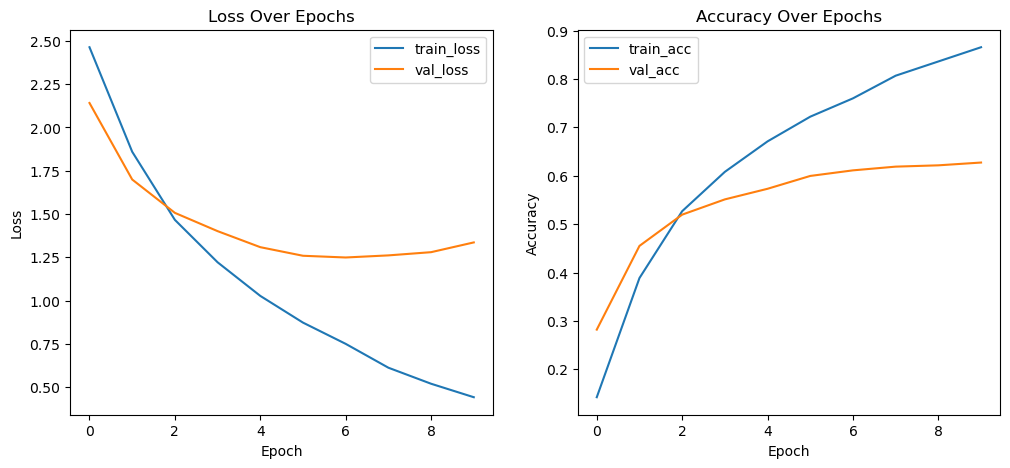

In [36]:
plot_training_history(history4)

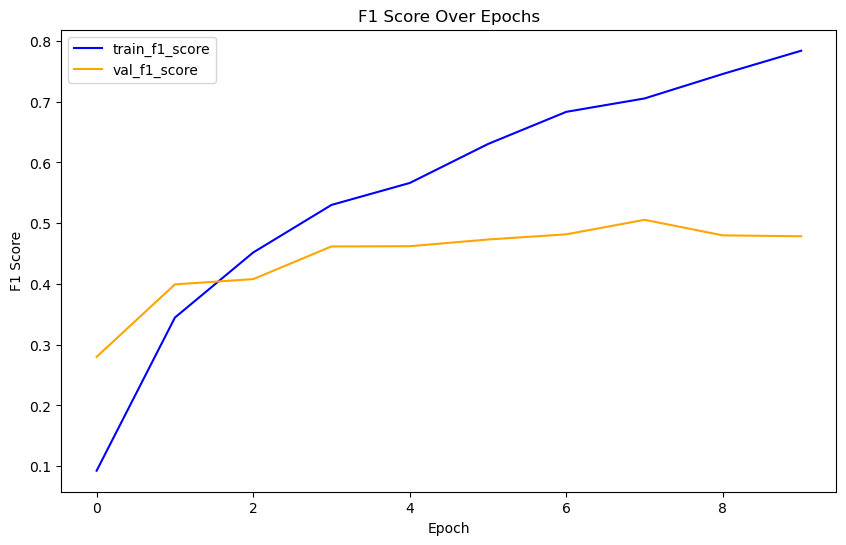

In [37]:
plot_f1_scores(history4)

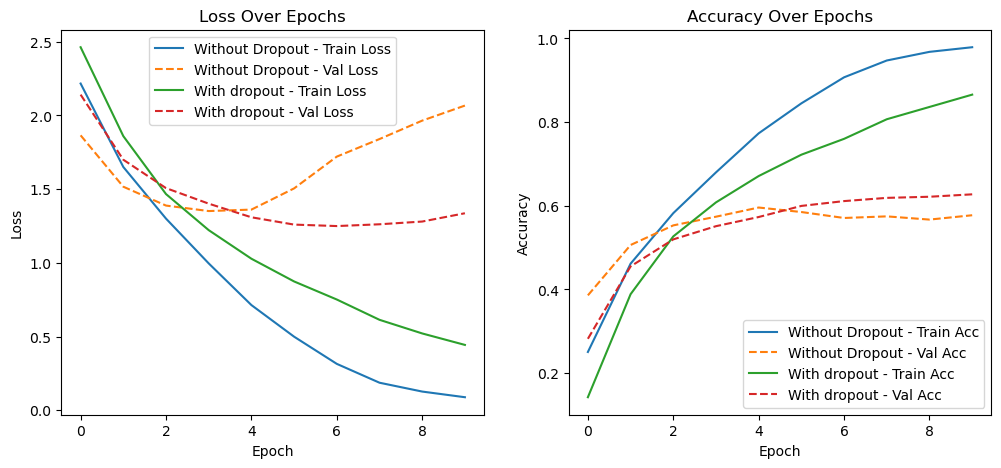

In [133]:
plot_comparison([history3, history4], ["Without Dropout", "With dropout"])

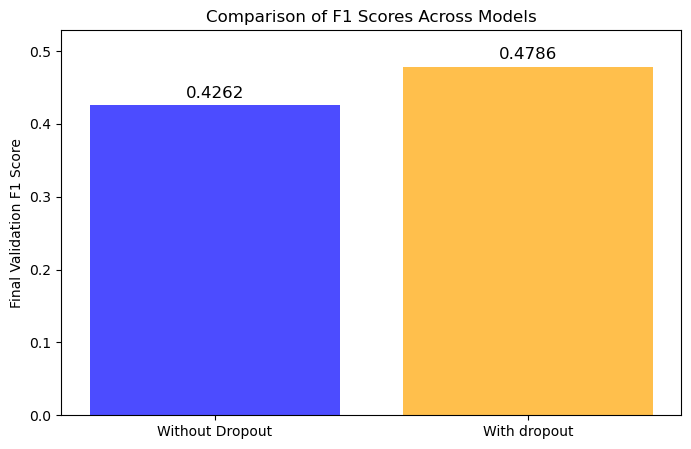

In [151]:
plot_f1_score_comparison([history3, history4], ["Without Dropout", "With dropout"])

In [177]:
display_results_table([history3, history4], ["Without Dropout", "With dropout"])

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Train F1,Val F1
0,Without Dropout,0.979,0.577,0.088,2.067,0.903,0.426
1,With dropout,0.866,0.627,0.443,1.336,0.784,0.479


### LSTM Layer Modifications
Experimenting with different configurations of the LSTM layer, adding a Bidirectional LSTM.

In [39]:
def build_cnn_lstm_model_lstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN part: extract spatial features
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)  # Stronger dropout for deeper layers
    
    # Reshape for LSTM layer
    shape = tf.keras.backend.int_shape(x)
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x) # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)
    
    # Bidirectional LSTM 
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile model with Bidirectional LSTM
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_lstm(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_score]) # Using custom F1 Score
model.summary()

# Train the model
history5 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_4 (Permute)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │     4,326,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,365 (16.92 MB)

 Trainable params: 4,436,365 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 282s 847ms/step - accuracy: 0.1207 - f1_score: 0.0629 - loss: 2.5007 - val_accuracy: 0.3646 - val_f1_score: 0.2812 - val_loss: 1.9509
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 264s 812ms/step - accuracy: 0.4049 - f1_score: 0.3365 - loss: 1.8107 - val_accuracy: 0.5319 - val_f1_score: 0.4576 - val_loss: 1.4462
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 289s 890ms/step - accuracy: 0.5808 - f1_score: 0.4989 - loss: 1.2934 - val_accuracy: 0.5900 - val_f1_score: 0.4800 - val_loss: 1.2794
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 284s 875ms/step - accuracy: 0.6715 - f1_score: 0.5789 - loss: 1.0076 - val_accuracy: 0.6273 - val_f1_score: 0.5433 - val_loss: 1.1732
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 282s 869ms/step - accuracy: 0.7479 - f1_score: 0.6622 - loss: 0.7751 - val_accuracy: 0.6281 - val_f1_score: 0.4560 - val_loss: 1.1784
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 284s 874ms/step - accuracy: 0.8119 - f1_score: 0.7264 - loss: 0.6060 - val_accuracy: 0.643

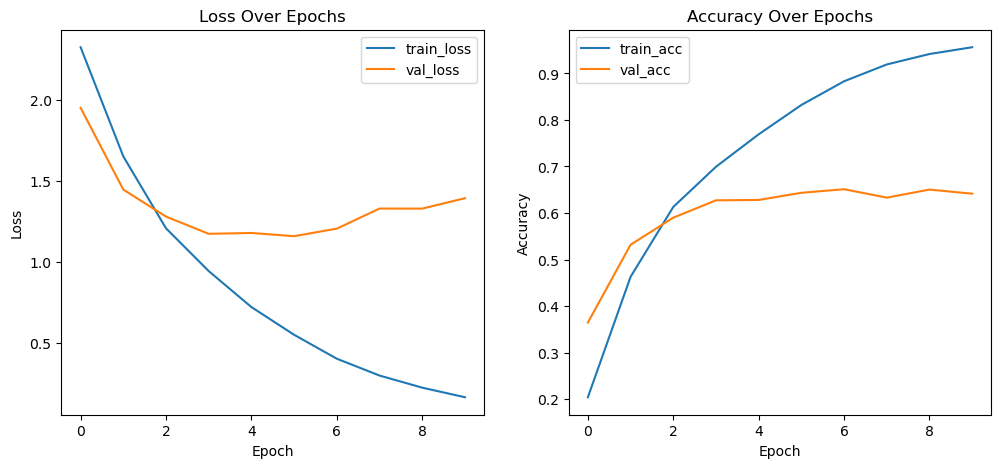

In [40]:
plot_training_history(history5)

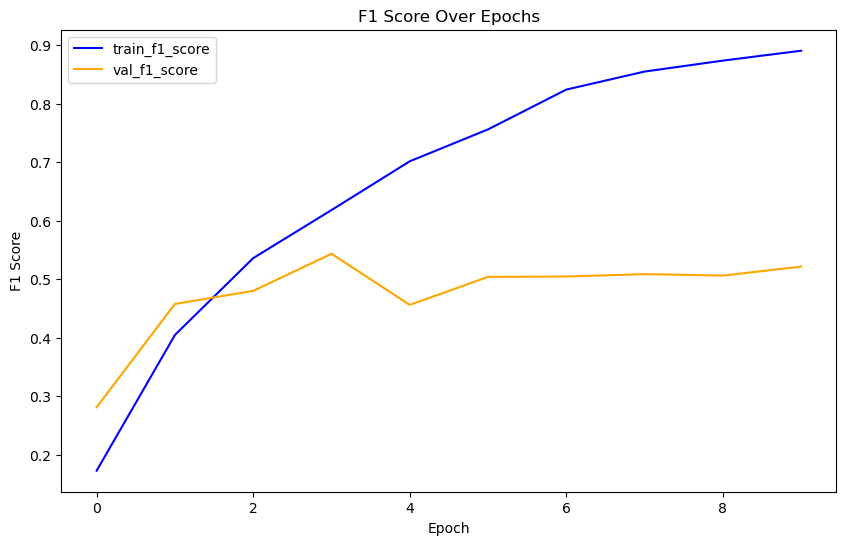

In [41]:
plot_f1_scores(history5)

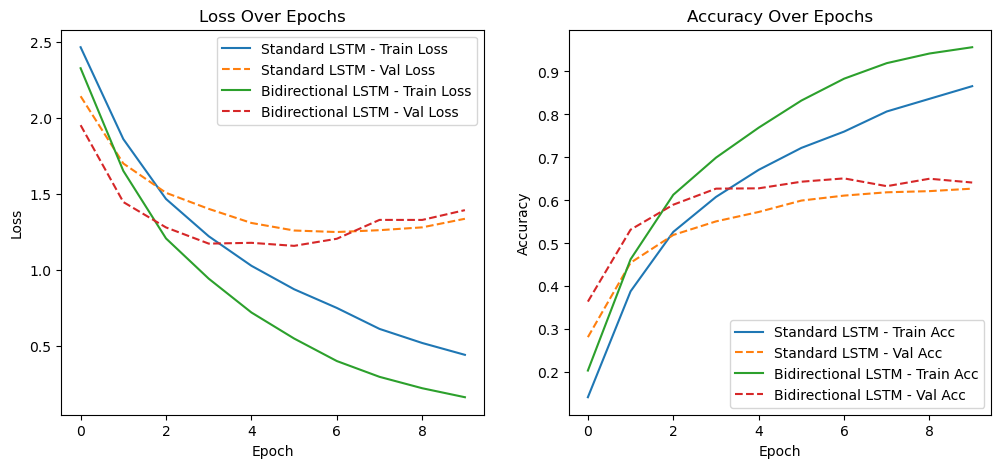

In [135]:
plot_comparison([history4, history5], ["Standard LSTM", "Bidirectional LSTM"])

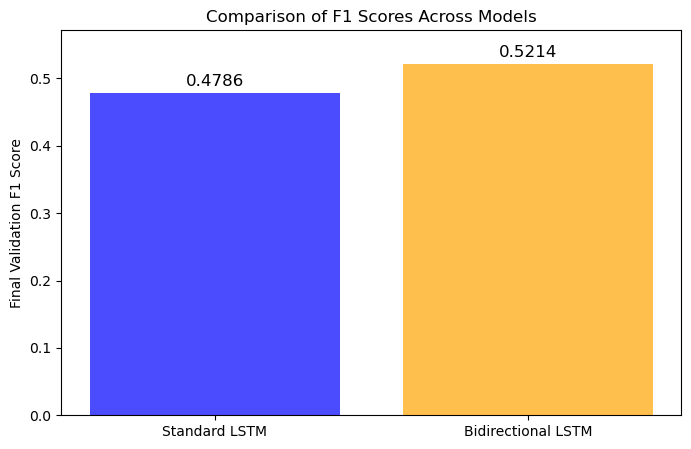

In [155]:
plot_f1_score_comparison([history4, history5], ["Standard LSTM", "Bidirectional LSTM"])

In [179]:
display_results_table([history4, history5], ["Standard LSTM", "Bidirectional LSTM"])

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Train F1,Val F1
0,Standard LSTM,0.866,0.627,0.443,1.336,0.784,0.479
1,Bidirectional LSTM,0.956,0.642,0.165,1.393,0.890,0.521


### Learning Rate Adjustments
Experimenting with different learning rates to see how it impacts convergence. A learning rate that's too large might cause the model to diverge, while a very small learning rate could lead to slow convergence.

#### Using a learning rate of 0.001 

In [44]:
def build_cnn_lstm_model_lr1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN part: extract spatial features
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)  # Stronger dropout for deeper layers
    
    # Reshape for LSTM layer
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x) # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)

    # Bidirectional LSTM 
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile model with Bidirectional LSTM
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_lr1(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",f1_score])
model.summary()

# Train the model
history6 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_5 (Permute)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │     2,163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,973 (8.64 MB)

 Trainable params: 2,264,973 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 241s 724ms/step - accuracy: 0.1218 - f1_score: 0.1052 - loss: 2.5085 - val_accuracy: 0.2835 - val_f1_score: 0.3433 - val_loss: 2.1363
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 236s 725ms/step - accuracy: 0.3356 - f1_score: 0.2987 - loss: 1.9906 - val_accuracy: 0.4469 - val_f1_score: 0.3812 - val_loss: 1.7068
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 244s 749ms/step - accuracy: 0.4791 - f1_score: 0.3837 - loss: 1.6015 - val_accuracy: 0.5212 - val_f1_score: 0.3937 - val_loss: 1.5147
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 246s 758ms/step - accuracy: 0.5713 - f1_score: 0.4795 - loss: 1.3332 - val_accuracy: 0.5508 - val_f1_score: 0.4514 - val_loss: 1.4078
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 242s 745ms/step - accuracy: 0.6405 - f1_score: 0.5361 - loss: 1.1065 - val_accuracy: 0.5850 - val_f1_score: 0.4618 - val_loss: 1.3409
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 237s 729ms/step - accuracy: 0.7024 - f1_score: 0.6152 - loss: 0.9360 - val_accuracy: 0.576

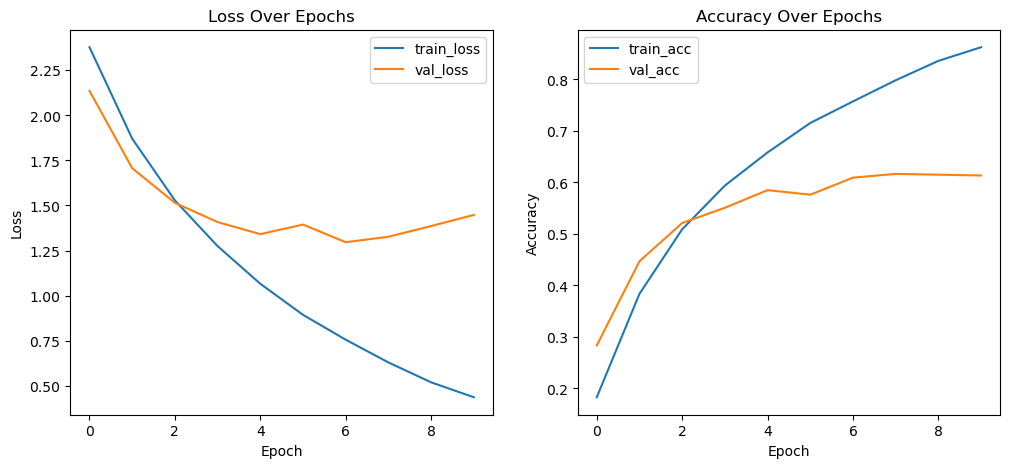

In [45]:
plot_training_history(history6)

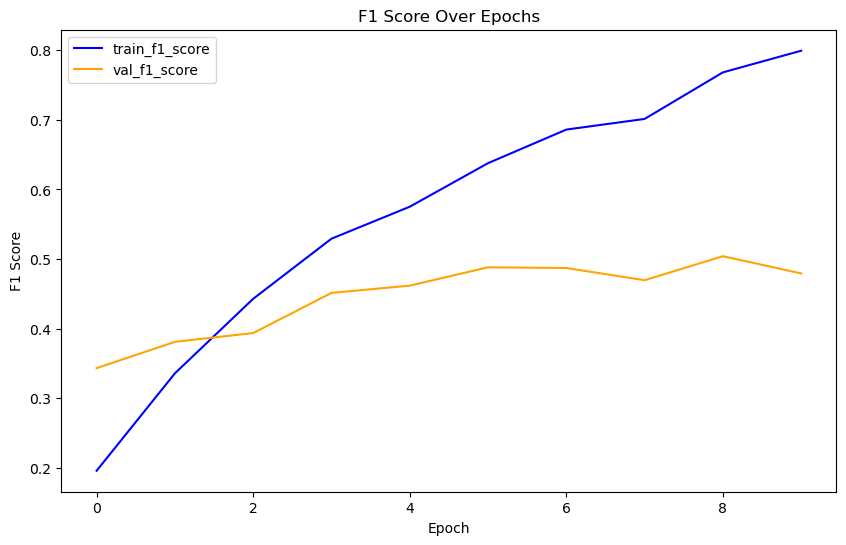

In [46]:
plot_f1_scores(history6)

#### Using a learning rate of 0.0005

In [48]:
def build_cnn_lstm_model_lr2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN part: extract spatial features
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)  # Stronger dropout for deeper layers
    
    # Reshape for LSTM layer
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x) # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)

    # Bidirectional LSTM 
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile model with Bidirectional LSTM
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_lr2(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",f1_score])
model.summary()

# Train the model
history7 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_6 (Permute)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │     2,163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,973 (8.64 MB)

 Trainable params: 2,264,973 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 256s 768ms/step - accuracy: 0.1164 - f1_score: 0.0562 - loss: 2.5061 - val_accuracy: 0.3258 - val_f1_score: 0.3311 - val_loss: 2.0521
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 232s 713ms/step - accuracy: 0.3601 - f1_score: 0.3191 - loss: 1.9471 - val_accuracy: 0.4692 - val_f1_score: 0.4078 - val_loss: 1.6642
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 232s 714ms/step - accuracy: 0.4953 - f1_score: 0.4168 - loss: 1.5446 - val_accuracy: 0.5354 - val_f1_score: 0.4821 - val_loss: 1.4712
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 234s 721ms/step - accuracy: 0.5860 - f1_score: 0.4843 - loss: 1.2783 - val_accuracy: 0.5515 - val_f1_score: 0.4561 - val_loss: 1.3817
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 232s 714ms/step - accuracy: 0.6494 - f1_score: 0.5346 - loss: 1.0838 - val_accuracy: 0.5808 - val_f1_score: 0.4575 - val_loss: 1.3044
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 239s 735ms/step - accuracy: 0.7022 - f1_score: 0.5866 - loss: 0.9138 - val_accuracy: 0.601

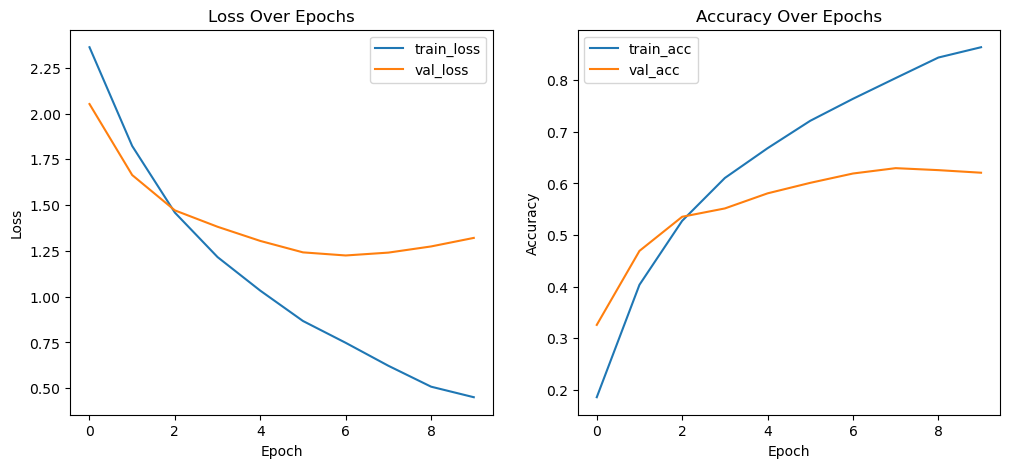

In [49]:
plot_training_history(history7)

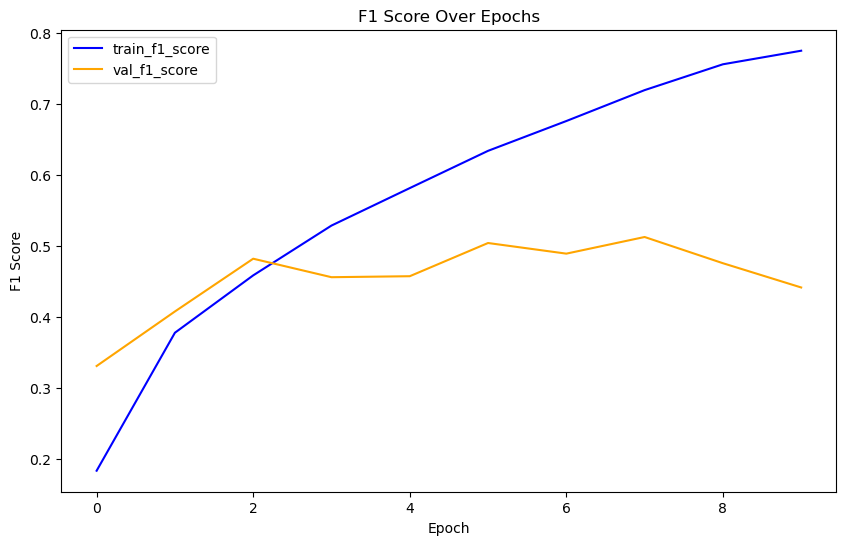

In [50]:
plot_f1_scores(history7)

#### Using a learning rate of 0.0001 

In [52]:
def build_cnn_lstm_model_lr3(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN part: extract spatial features
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)  # Dropout added here
    
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)  # Stronger dropout for deeper layers
    
    # Reshape for LSTM layer
    shape = tf.keras.backend.int_shape(x)
    # Treat the width dimension as the time dimension.
    time_steps = shape[2]  # width
    features = shape[1] * shape[3]  # height * channels
    x = layers.Permute((2,1,3))(x) # now shape: (batch, width, height, channels)
    x = layers.Reshape((time_steps, features))(x)

    # Bidirectional LSTM 
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    
    # Final Dense layers for classification
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build and compile model with Bidirectional LSTM
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_lr3(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy",f1_score])
model.summary()

# Train the model
history8 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)



Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_7 (Permute)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │     2,163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,973 (8.64 MB)

 Trainable params: 2,264,973 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 231s 695ms/step - accuracy: 0.0635 - f1_score: 0.0140 - loss: 2.5751 - val_accuracy: 0.0769 - val_f1_score: 0.0000e+00 - val_loss: 2.5639
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 226s 697ms/step - accuracy: 0.0950 - f1_score: 0.0322 - loss: 2.5396 - val_accuracy: 0.2392 - val_f1_score: 0.3040 - val_loss: 2.2565
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 224s 690ms/step - accuracy: 0.2667 - f1_score: 0.2808 - loss: 2.1799 - val_accuracy: 0.2946 - val_f1_score: 0.3114 - val_loss: 2.0636
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 225s 693ms/step - accuracy: 0.3492 - f1_score: 0.2969 - loss: 1.9648 - val_accuracy: 0.3815 - val_f1_score: 0.3226 - val_loss: 1.9131
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 225s 692ms/step - accuracy: 0.4192 - f1_score: 0.3405 - loss: 1.7792 - val_accuracy: 0.4262 - val_f1_score: 0.3391 - val_loss: 1.7879
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 225s 694ms/step - accuracy: 0.4932 - f1_score: 0.3641 - loss: 1.6005 - val_accuracy: 0

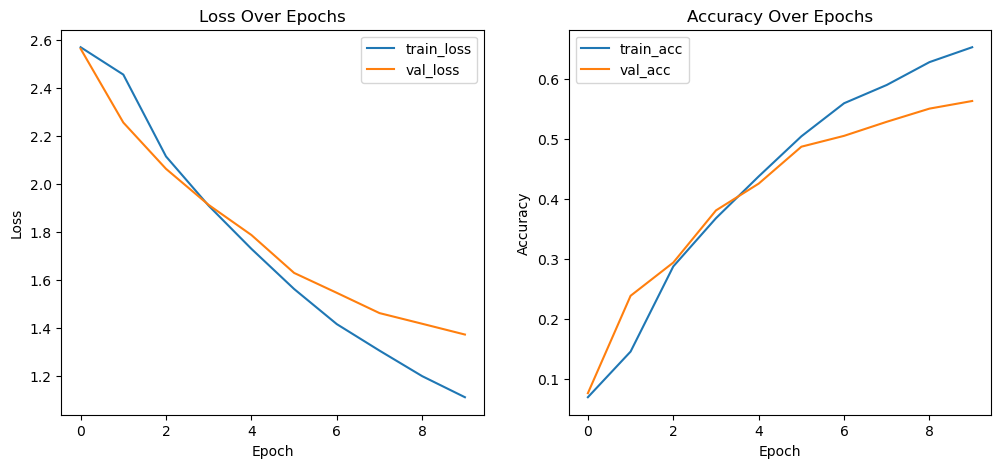

In [53]:
plot_training_history(history8)

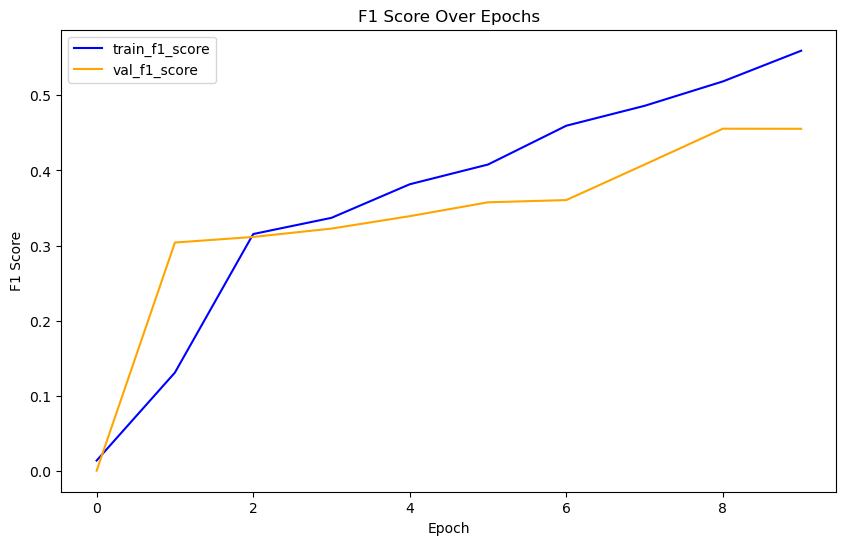

In [54]:
plot_f1_scores(history8)

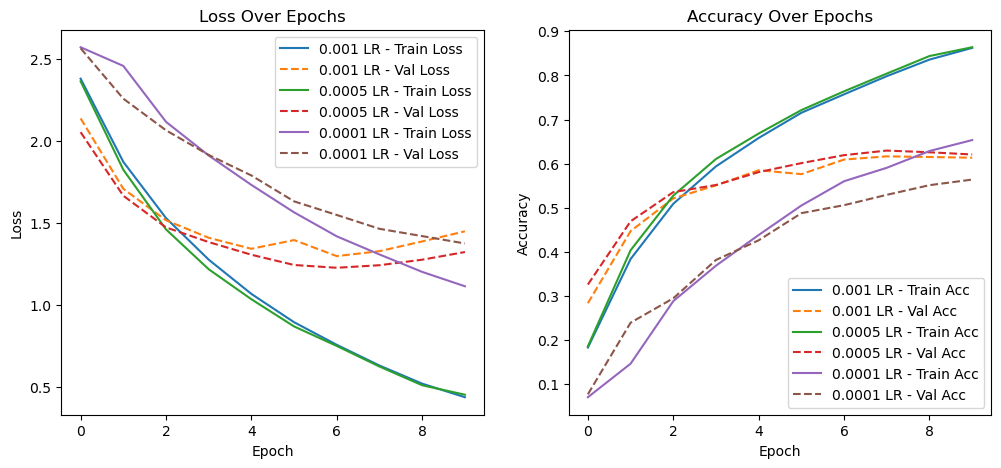

In [157]:
plot_comparison([history6, history7, history8], ["0.001 LR", "0.0005 LR", "0.0001 LR"])

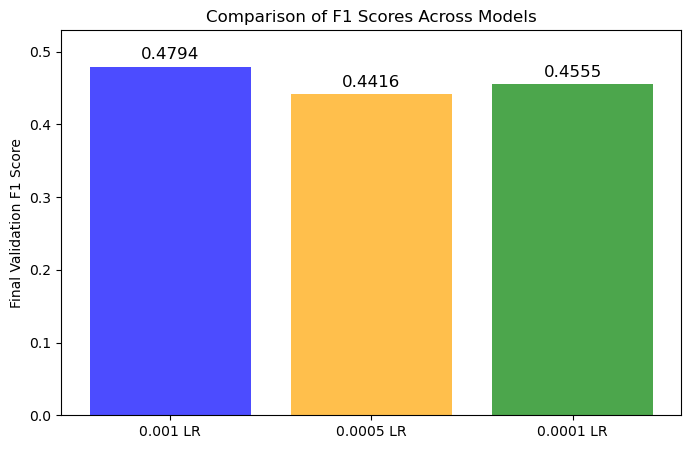

In [159]:
plot_f1_score_comparison([history6, history7, history8], ["0.001 LR", "0.0005 LR", "0.0001 LR"])

In [181]:
display_results_table([history6, history7, history8], ["0.001 LR", "0.0005 LR", "0.0001 LR"])

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Train F1,Val F1
0,0.001 LR,0.863,0.613,0.435,1.447,0.799,0.479
1,0.0005 LR,0.864,0.621,0.451,1.321,0.775,0.442
2,0.0001 LR,0.653,0.564,1.112,1.373,0.559,0.456


### K-Fold Cross-Validation
K-fold cross-validation can help ensure that the model's performance is stable across different splits of the data. I will use the KFold module from sklearn to perform K-fold cross-validation.

In [90]:
def k_fold_cross_validation(model, X, y, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_results = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=10,
                  batch_size=32)
        
        score = model.evaluate(X_val, y_val, verbose=0)
        cv_results.append(score[1])  # Accuracy
        
    print(f"Mean accuracy across {k} folds: {np.mean(cv_results)}")
    return np.mean(cv_results)

# Build the model
input_shape = (256, 256, 1)
model = build_cnn_lstm_model_lr2(input_shape, num_classes)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_score])

# Perform K-Fold cross-validation
mean_accuracy = k_fold_cross_validation(model, X_train, y_train, k=5)
print(f"Mean accuracy: {mean_accuracy}")


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 192s 715ms/step - accuracy: 0.1030 - f1_score: 0.0473 - loss: 2.5377 - val_accuracy: 0.3207 - val_f1_score: 0.3966 - val_loss: 2.0510
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 184s 706ms/step - accuracy: 0.3526 - f1_score: 0.3027 - loss: 1.9758 - val_accuracy: 0.4202 - val_f1_score: 0.4437 - val_loss: 1.7663
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 180s 691ms/step - accuracy: 0.4726 - f1_score: 0.4211 - loss: 1.6239 - val_accuracy: 0.5034 - val_f1_score: 0.4952 - val_loss: 1.5245
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 180s 694ms/step - accuracy: 0.5590 - f1_score: 0.5052 - loss: 1.3679 - val_accuracy: 0.5630 - val_f1_score: 0.5130 - val_loss: 1.3755
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 180s 694ms/step - accuracy: 0.6240 - f1_score: 0.5414 - loss: 1.1748 - val_accuracy: 0.5803 - val_f1_score: 0.5533 - val_loss: 1.2933
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 180s 693ms/step - accuracy: 0.6744 - f1_score: 0.5836 - loss: 1.0153 - val_accuracy: 0.578

In [227]:
def display_kfold_results_table(histories, model_names):
    results = []

    for name, history in zip(model_names, histories):
        # Extract values from the history dictionary
        mean_accuracy = history["Mean Accuracy"]
        mean_loss = history["Mean Loss"]
        mean_f1 = history["Mean F1 Score"]

        results.append([name, mean_accuracy, mean_loss, mean_f1])

    # Create a Pandas DataFrame
    df = pd.DataFrame(results, columns=["Model", "Mean Accuracy", "Mean Loss", "Mean F1"])

    # Apply styling for better presentation
    styled_df = df.style.set_caption("K-Fold Cross-Validation Results") \
        .format({
            "Mean Accuracy": "{:.5f}",
            "Mean Loss": "{:.5f}",
            "Mean F1": "{:.5f}"
        }) \
        .set_table_styles([
            {"selector": "caption", "props": "font-size:16px; font-weight:bold; color:#333; text-align: center;"},
            {"selector": "thead th", "props": "background-color: #4CAF50; color: white; font-weight: bold;"},
            {"selector": "tbody td", "props": "text-align: center; font-size: 12px;"},
            {"selector": "tbody tr:nth-child(even)", "props": "background-color: #f2f2f2;"},
            {"selector": "tbody tr:hover", "props": "background-color: #ddd;"}
        ])

    # Display the styled table
    display(styled_df)

# Display the table
display_kfold_results_table([history11], ["K-Fold Cross-Validation"])



,Model,Mean Accuracy,Mean Loss,Mean F1
0,K-Fold Cross-Validation,0.84412,0.53572,0.77474


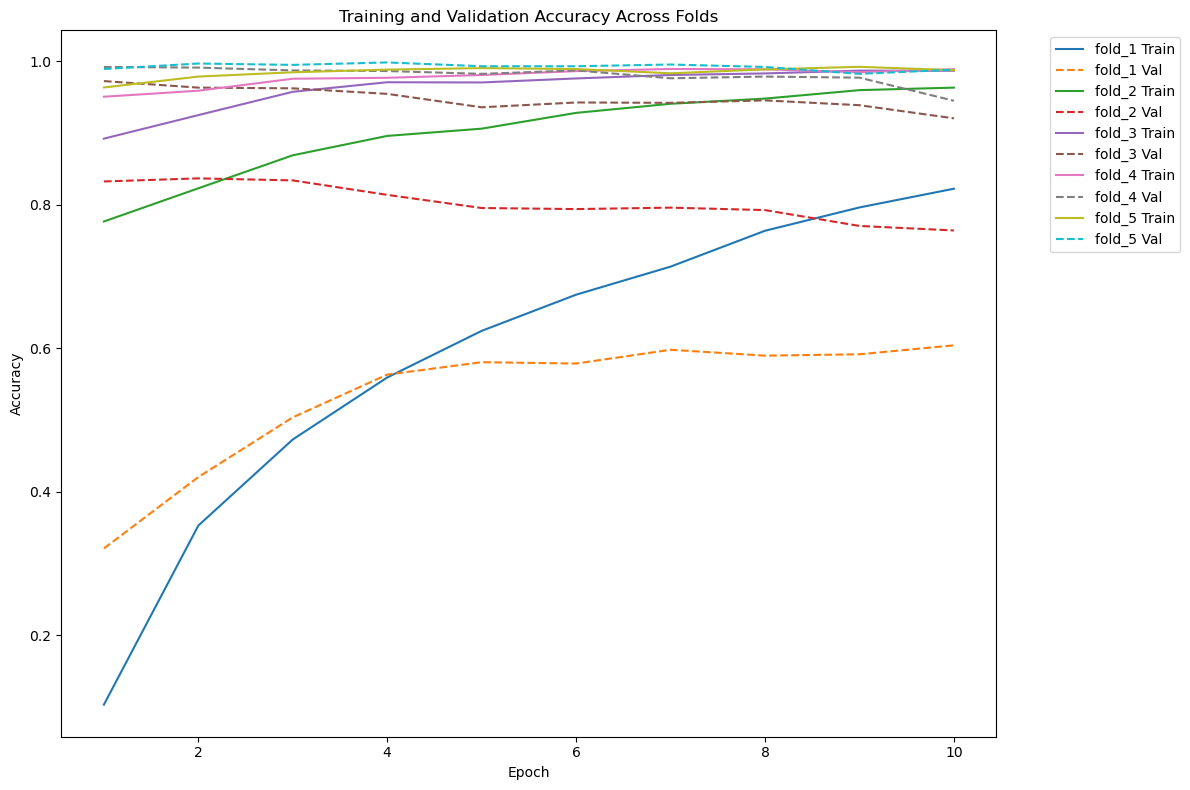

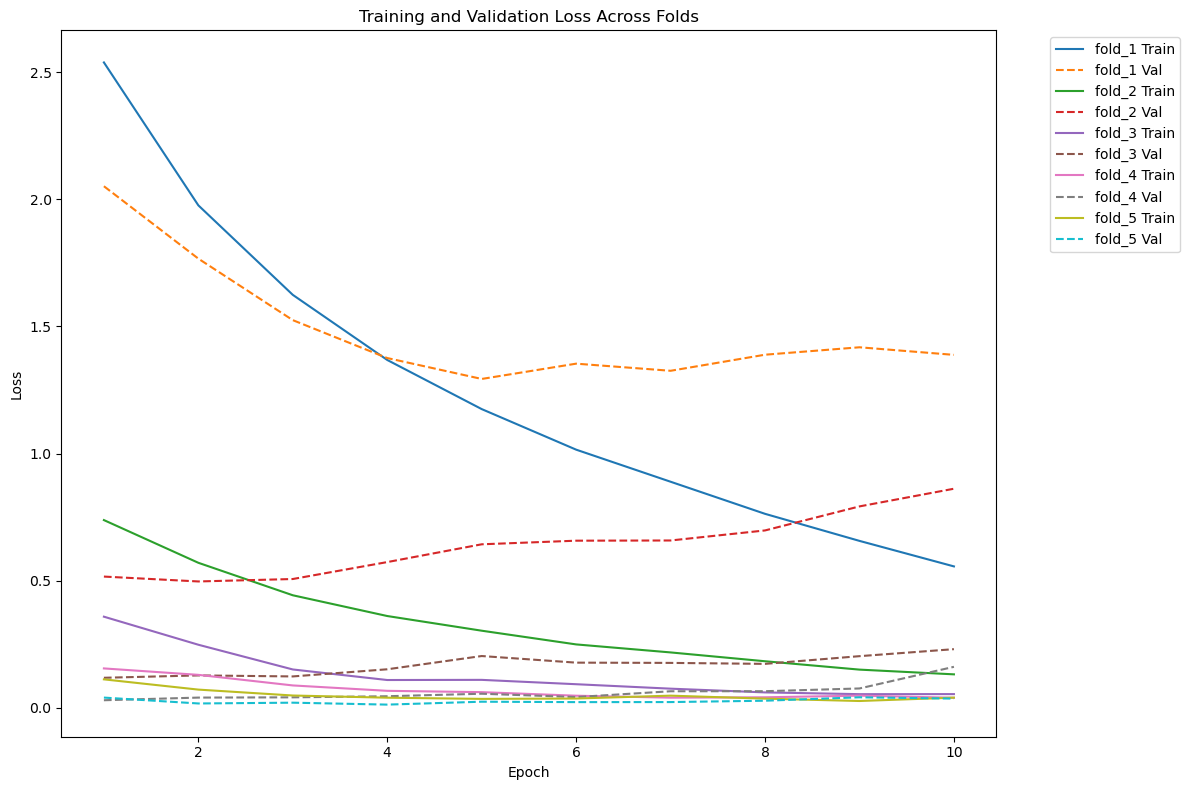

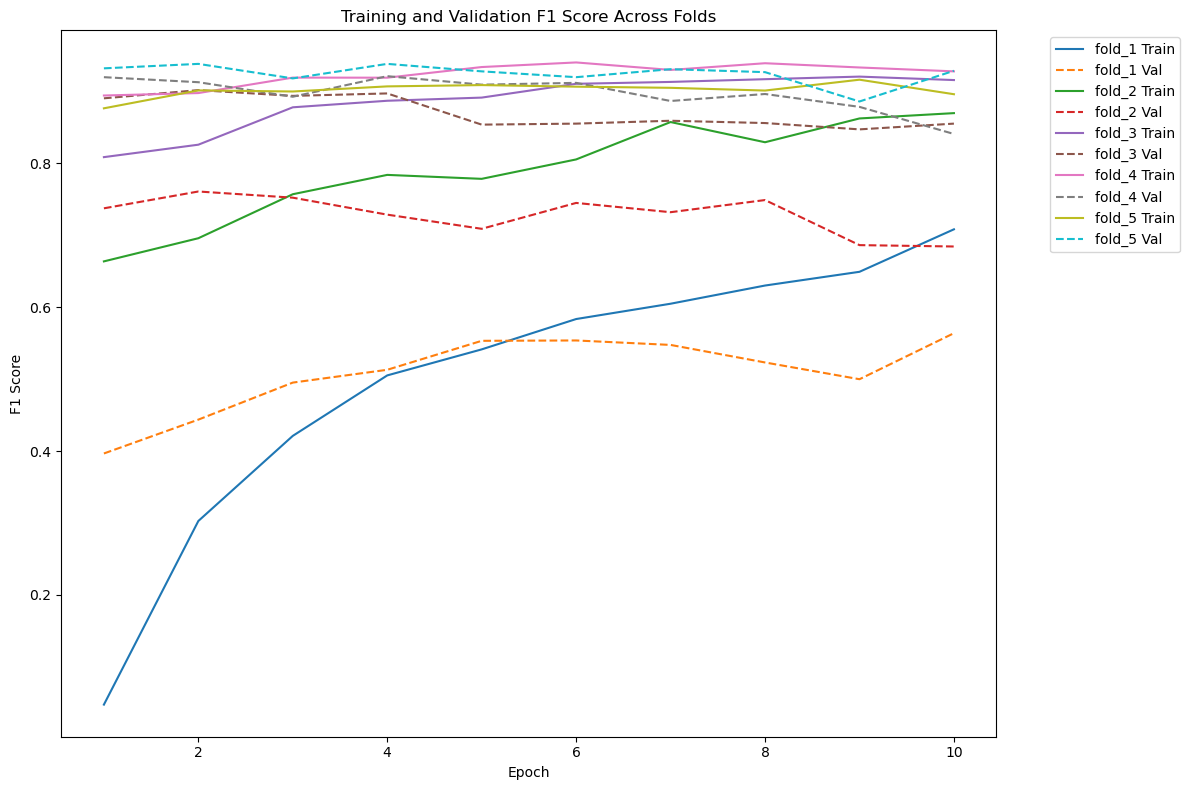

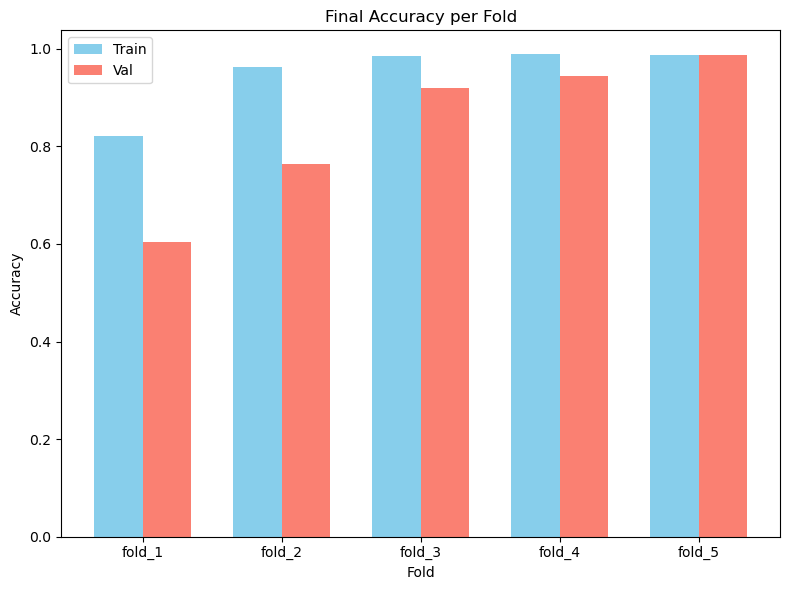

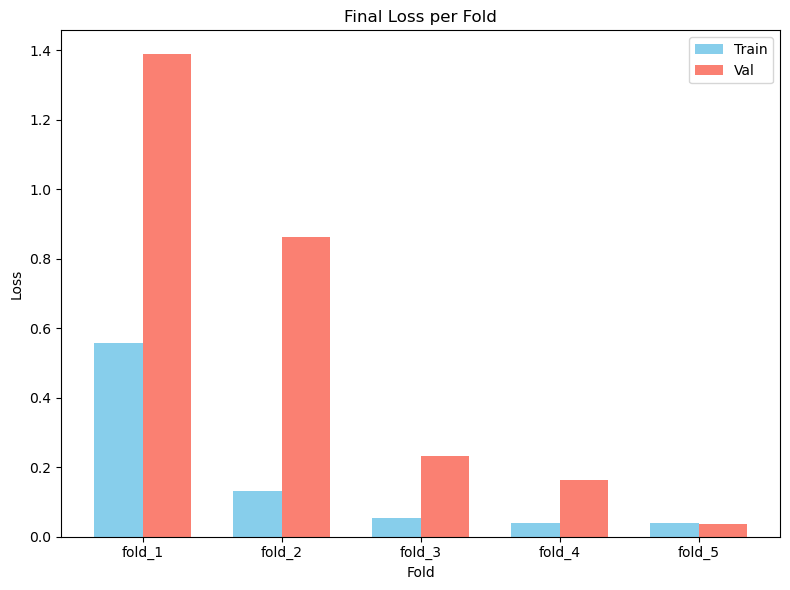

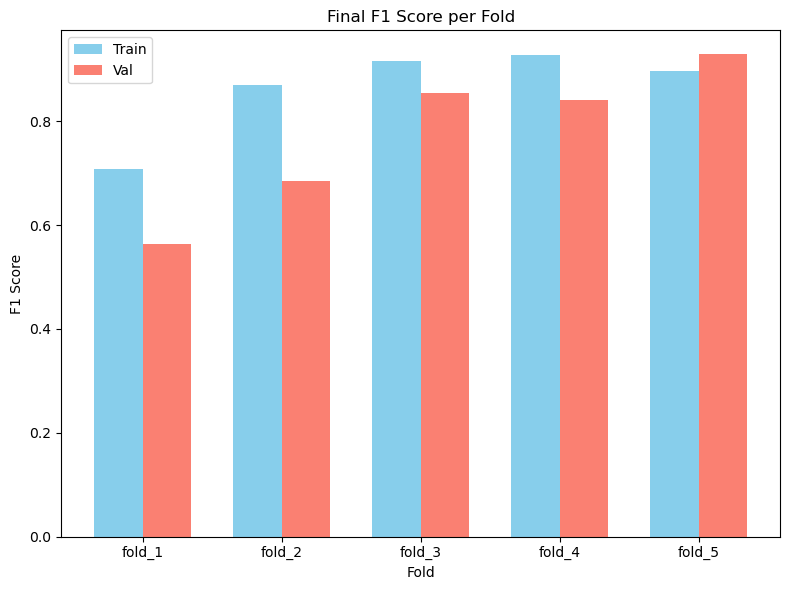

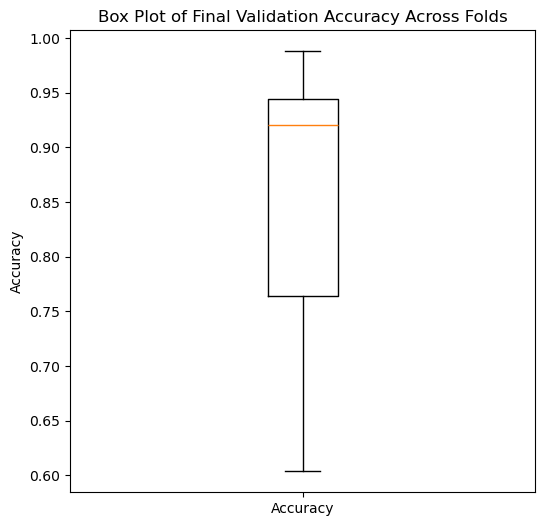

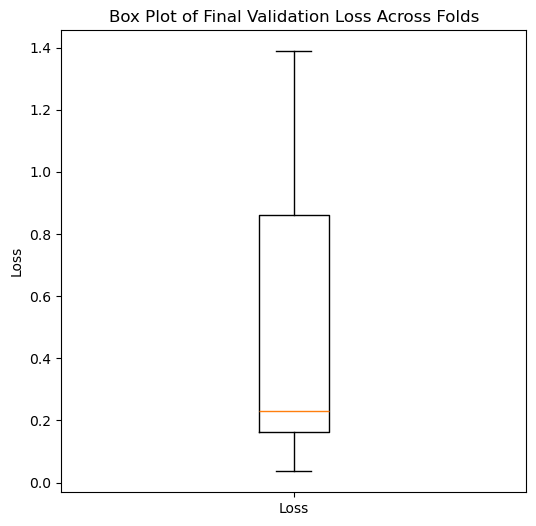

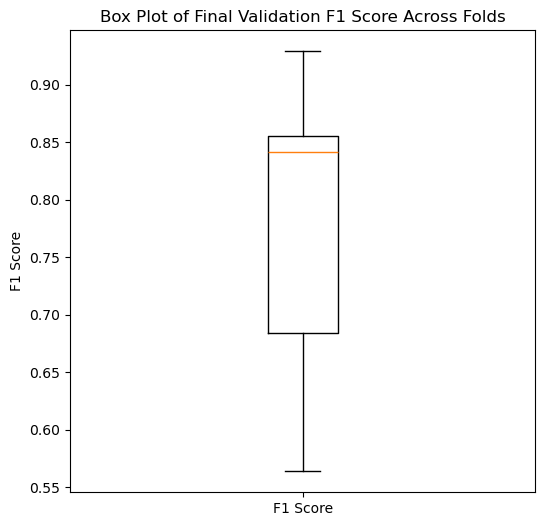

In [207]:
# Extract the fold names from the history dictionary
fold_names = list(history9["folds"].keys())

# Define the metrics to be analyzed
metrics = ["accuracy", "loss", "f1_score"]

# --- 1. Line Plots for Each Metric Across Epochs ---
for metric in metrics:
    plt.figure(figsize=(12, 8))
    for fold in fold_names:
        train_metric = history9["folds"][fold][f"train_{metric}"]
        val_metric = history9["folds"][fold][f"val_{metric}"]
        epochs = np.arange(1, len(train_metric) + 1)
        plt.plot(epochs, train_metric, label=f"{fold} Train")
        plt.plot(epochs, val_metric, '--', label=f"{fold} Val")
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"Training and Validation {metric.replace('_', ' ').title()} Across Folds")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# --- 2. Bar Charts for Final Epoch Metrics Across Folds ---
# Create a dictionary to store final values for each metric
final_values = {metric: {"train": [], "val": []} for metric in metrics}
for fold in fold_names:
    for metric in metrics:
        final_values[metric]["train"].append(history9["folds"][fold][f"train_{metric}"][-1])
        final_values[metric]["val"].append(history9["folds"][fold][f"val_{metric}"][-1])

# Plot bar charts for each metric: final train and validation values per fold
for metric in metrics:
    plt.figure(figsize=(8,6))
    x = np.arange(len(fold_names))
    width = 0.35
    plt.bar(x - width/2, final_values[metric]["train"], width, label="Train", color="skyblue")
    plt.bar(x + width/2, final_values[metric]["val"], width, label="Val", color="salmon")
    plt.xlabel("Fold")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"Final {metric.replace('_', ' ').title()} per Fold")
    plt.xticks(x, fold_names)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. Box Plot for Final Validation Metrics ---
for metric in metrics:
    # Collect final validation metric across folds
    data = [history9["folds"][fold][f"val_{metric}"][-1] for fold in fold_names]
    plt.figure(figsize=(6,6))
    plt.boxplot(data, labels=[metric.replace("_", " ").title()])
    plt.title(f"Box Plot of Final Validation {metric.replace('_', ' ').title()} Across Folds")
    plt.ylabel(metric.replace("_", " ").title())
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


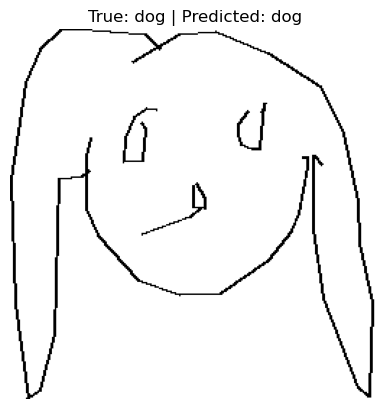

In [23]:
# Select one sample from validation set
sample_img = X_val[15]
sample_label = y_val[15]
prediction = model.predict(np.expand_dims(sample_img, axis=0))
predicted_class = le.inverse_transform([np.argmax(prediction)])

plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title(f"True: {le.inverse_transform([sample_label])[0]} | Predicted: {predicted_class[0]}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


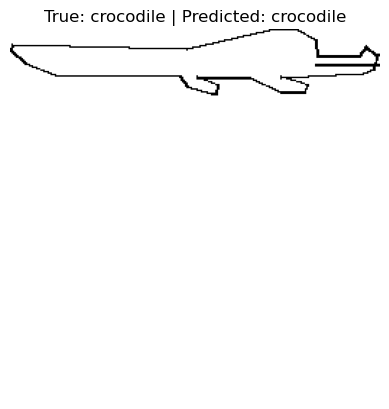

In [33]:
# Select one sample from validation set
sample_img = X_val[16]
sample_label = y_val[16]
prediction = model.predict(np.expand_dims(sample_img, axis=0))
predicted_class = le.inverse_transform([np.argmax(prediction)])

plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title(f"True: {le.inverse_transform([sample_label])[0]} | Predicted: {predicted_class[0]}")
plt.axis("off")
plt.show()